####Importing all necessary packages

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import random
import tensorflow as tf
import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

####Reading the dataset

In [ ]:
!unzip new_dataset.zip

In [ ]:
#загружаем изображения в массив dataset

dataset = []
for imagename in os.listdir('new_dataset/'):
    dataset.append(img_to_array(load_img('new_dataset/'+imagename)))
dataset = np.array(dataset, dtype=float)

#получаем тестовое множество

split = int(0.9*len(dataset))
Xtrain = dataset[:split]
Xtrain = 1.0/255*Xtrain
print(Xtrain.shape)

(1305, 256, 256, 3)


In [ ]:
Xtest = rgb2lab(1.0/255*dataset[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*dataset[split:])[:,:,:,1:]
Ytest = Ytest / 128

####Creating the model

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

In [ ]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)
batch_size = 50

def generate_training_data(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)          
        Xbatch = lab_batch[:,:,:,0]         
        Ybatch = lab_batch[:,:,:,1:] / 128  
        yield (Xbatch.reshape(Xbatch.shape+(1,)), Ybatch)
tensorboard = TensorBoard(log_dir="/output/beta_run") 
trainedmodel = model.fit_generator(generate_training_data(batch_size), 
                                   callbacks=[tensorboard],epochs=100, steps_per_epoch = 29, validation_data = (Xtest, Ytest))

plt.plot(trainedmodel.history['acc'])
plt.plot(trainedmodel.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(trainedmodel.history['loss'])
plt.plot(trainedmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
!unzip images.zip

####Saving the model

In [ ]:
# сохраняем модель
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

####Results

Результаты работы модели


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


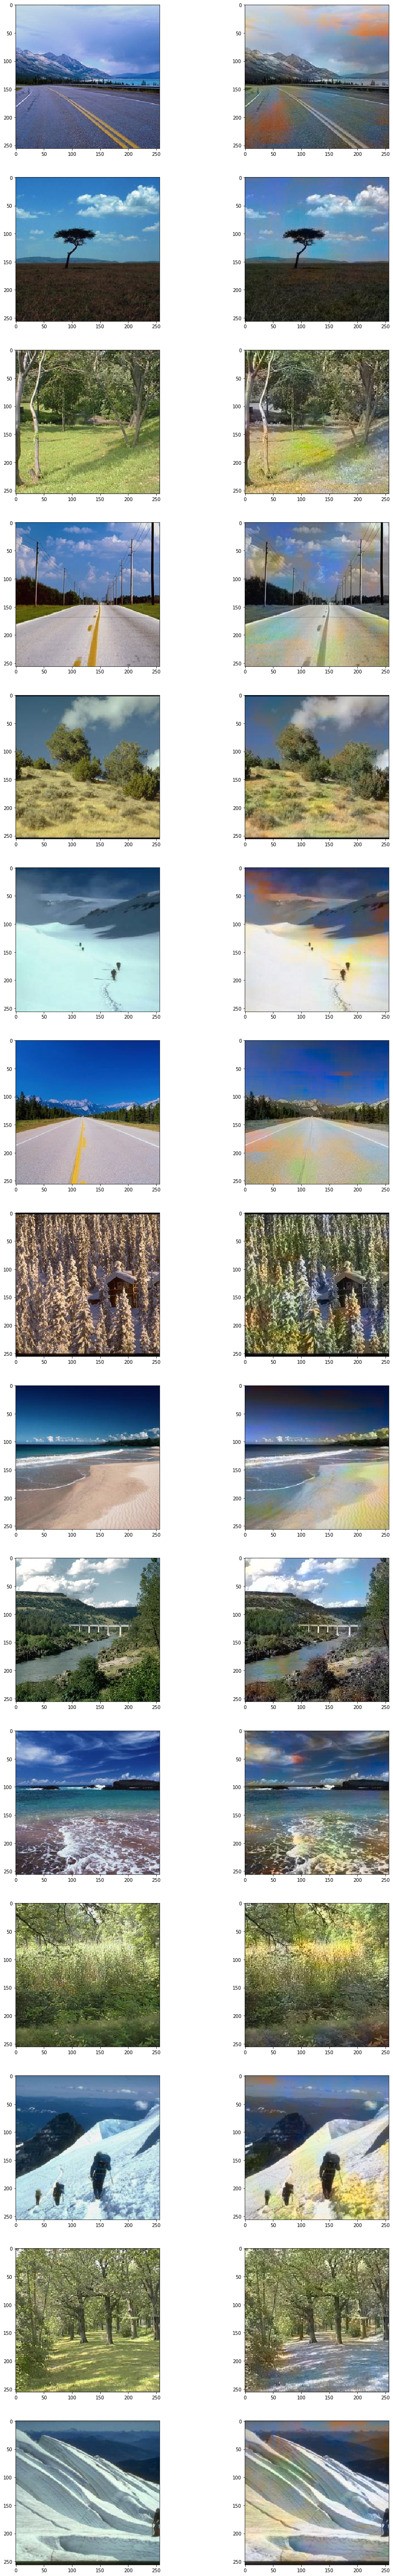

In [ ]:
fig, ax = plt.subplots(15, 2, figsize=(16,100))
row = 0
colorize = []
print('Результаты работы модели')
for filename in os.listdir('test/'):
    colorize.append(img_to_array(load_img('test/'+filename))) 
    ax[row,0].imshow(load_img('test/'+filename), interpolation='nearest') 
    row +=1
colorize = np.array(colorize, dtype=float) 
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))
output = model.predict(colorize)
output = output * 128 
row = 0
for i in range(len(output)):
    canvas = np.zeros((256, 256, 3))
    canvas[:,:,0] = colorize[i][:,:,0]
    canvas[:,:,1:] = output[i]
    resImage = lab2rgb(canvas)
    ax[row,1].imshow(resImage, interpolation='nearest')
    row +=1
    imsave("result/img_"+str(i)+".png", resImage)